In [709]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import pandas as pd  
import numpy as np  

import tools.Sample_Tools as smpl
# import tools.Pretreat_Tools as pretreat
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)



import matplotlib.pyplot as plt
import seaborn as sns

from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates

# import statsmodels.api as sm

from sklearn.decomposition import FactorAnalysis

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

# from scipy.optimize import minimize

# from QUANTAXIS.QAUtil import DATABASE
# from QUANTAXIS.QAUtil import  trade_date_sse
# from QUANTAXIS.QAUtil.QADate_trade import (
#     QA_util_get_pre_trade_date,
#     QA_util_get_next_trade_date,
#     QA_util_if_tradetime
# )

# import inspect
import warnings


# from sklearn import linear_model
# import ind.alpha101 as a101


In [8]:
###加载数据

ids = np.arange(1,101)
# np.random.shuffle(ids)
files = list(map(lambda x:'alpha'+str(x)+'_train',ids))

def load_alpha_factors(file_names):
    from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)
    from base.JuUnits import excute_for_multidates
    import numpy as np
    import pandas as pd 
    
    temp = []
    for file in file_names:
        print(file)
        temp.append(load_cache(file, cache_type=CACHE_TYPE.FACTOR))
    
    return pd.concat(temp,axis=1)
        
worker=6
task = task_chunk_split(files, worker)
results = parallal_task(worker, load_alpha_factors, task)
a101 = pd.concat(results,axis=1)

Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:8020  pid:6004


  0%|          | 0/6 [00:00<?, ?it/s]

In [469]:
removed = a101.columns.difference(['alpha27','alpha61','alpha68','alpha75','alpha86','alpha95'],sort=False) 
tmp = a101.loc[(slice('2016-01-04','2020-12-24'),'000001'),:][removed].dropna()

tmp2 = tmp[tmp.columns[0:100]].reset_index('code',drop=True)
tmp2 = (tmp2 - tmp2.mean())/tmp2.std()
tmp2

,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,...,alpha90,alpha91,alpha92,alpha93,alpha94,alpha96,alpha97,alpha98,alpha99,alpha100
date,,,,,,,,,,,,,,,,,,,,,
2017-01-25,0.259451,0.115124,1.652865,-1.180885,0.760456,1.710567,0.232956,-0.275087,0.044539,0.092444,...,0.057361,0.965002,-1.178915,-0.154605,0.892660,-0.188438,-0.411407,-0.994588,1.042573,0.075300
2017-02-03,0.259451,0.823263,2.236424,-0.518284,0.789404,2.214039,0.232956,-0.006101,0.257652,0.618138,...,0.567380,1.042770,-1.178915,-0.122159,0.127685,0.311036,-1.202115,-0.622378,-0.957712,0.111583
2017-02-06,-0.380060,-0.191097,2.052928,-1.015235,0.769202,2.014560,-1.293454,-0.256628,-0.168577,-0.517151,...,0.151893,1.111795,-1.178915,-0.100933,0.785454,0.311036,-1.199856,-0.376342,-0.957712,0.079707
2017-02-07,-0.968651,0.100002,1.830614,-1.180885,0.726188,1.784732,0.232956,-0.074666,0.044539,0.092444,...,0.265747,1.269171,-1.178915,-0.085853,1.109020,0.311036,-1.197920,-0.145626,-0.957712,0.044042
2017-02-08,-1.527287,0.468828,1.158669,0.144316,0.620477,1.357849,0.232956,-0.003464,0.009019,-0.011121,...,0.265747,1.398018,-0.792193,-0.085046,0.913413,0.311036,-1.195660,0.374386,-0.957712,-0.026632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-18,-0.380060,1.490503,-0.710892,0.806917,-0.762443,-0.697704,1.184484,-0.631098,2.229528,1.556784,...,1.127345,1.089247,-1.178915,0.167352,0.723289,-0.188438,-0.656043,0.833114,1.042573,-0.014983
2020-12-21,-0.968651,1.341405,0.277768,1.469518,0.444046,0.530952,1.263778,-0.604727,0.310109,0.730881,...,1.128156,1.180359,-1.178915,0.355950,1.303652,-0.188438,-0.632805,0.734880,1.042573,0.019504
2020-12-22,-1.527287,1.815401,0.636086,1.469518,0.959911,1.057689,1.501660,-0.902721,1.439170,-1.424334,...,1.128719,1.109494,-1.178915,1.067786,1.320110,-0.188438,-1.010409,0.921435,1.042573,-0.015984


In [420]:

# chi_square_value, p_value = calculate_bartlett_sphericity(tmp2)
# print(chi_square_value,p_value)

# Value of KMO less than 0.6 is considered inadequate
kmo_all, kmo_model = calculate_kmo(tmp2)
print(kmo_model)

47484.653841311265 0.0
0.8788547506629864


D:\Anaconda3\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [619]:
# res.shape
# fa.n_factors
# np.corrcoef(fa.loadings_[:,1], fa.loadings_[:,2])[0][1]

# if np.isnan(kmo_model) or kmo_model<0.6:
#     print(1)
# np.isnan(kmo_model)    
selected_standard.index.get_level_values(1).unique()

Index(['000069', '000596', '000723', '000768', '000792', '000800', '000858',
       '000895', '000938', '000963',
       ...
       '601066', '002938', '601319', '603185', '601615', '601865', '600989',
       '601236', '601698', '601658'],
      dtype='object', name='code', length=237)

init
0


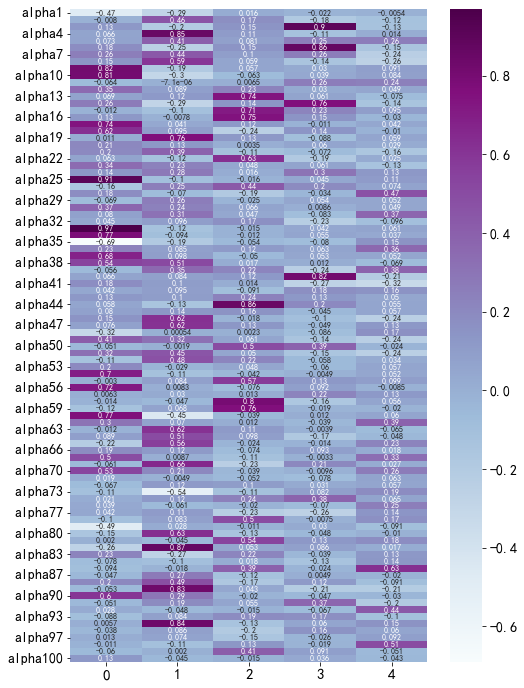

In [ ]:
# codes = smpl.get_codes_by_zs('沪深300')
# 

# excluded = a101.columns.difference(['alpha27','alpha61','alpha68','alpha75','alpha86','alpha95'],sort=False) 
# selected = a101.loc[(slice('2016-01-04','2020-12-24'),codes),:][excluded].dropna()
# selected_standard = excute_for_multidates(selected,lambda x:(x-x.mean())/x.std(), level=1)
n_factors = 5
fa = FactorAnalyzer(n_factors,rotation='promax',method='minres')

res = np.zeros((len(selected.columns),n_factors))
statistic = []
def mixing_fa(cum_res,new_res):
    n_factors = new_res.shape[1]
    
    if not cum_res.any():
        cum_res+=new_res
        print('init')
        print('===========')
        return
    
    cum_unmatch_cols = list(range(n_factors))
    blank_stat = np.zeros_like(new_res)
    for i_col in range(n_factors):
        new_col = new_res[:,i_col]
        if len(cum_unmatch_cols)>1:
            max_index = np.argmax([np.corrcoef(new_col, cum_res[:,j_col])[0][1] for j_col in cum_unmatch_cols])
            match_col_index = cum_unmatch_cols[max_index]
            cum_unmatch_cols.pop(max_index)
        else:
            match_col_index = cum_unmatch_cols[0]
            
        cum_res[:,match_col_index] = cum_res[:,match_col_index]*.5 + new_col*.5
        blank_stat[:,match_col_index] = blank_stat[:,match_col_index] + new_col
    global statistic
    statistic.append(blank_stat.argmax(axis=1))

print_count=-1
def cum_fa(single_stock_df,result):
    global print_count
    print_count+=1
    
    df = single_stock_df.reset_index('code',drop=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _, kmo_model = calculate_kmo(df)
    if np.isnan(kmo_model) or kmo_model<0.6:
        print(single_stock_df.index.get_level_values(1)[0],' skip!! value:',kmo_model)
        return
    fa.fit(df)
    mixing_fa(res,fa.loadings_)
    
    if print_count % int(len(selected_standard.index.get_level_values(1).unique())/2) == 0 :
        print(print_count)
        df_cm = pd.DataFrame(result, index=single_stock_df.columns)  
        fig,ax = plt.subplots(figsize=(8,12))
        sns.heatmap(df_cm,annot=True,cmap='BuPu',annot_kws={"size":8},ax=ax)
        ax.tick_params(axis='x',labelsize=15)
        plt.show()

excute_for_multidates(selected_standard,lambda x:cum_fa(x,res), level=1)

In [ ]:
statistic = np.array(statistic)
count = statistic.shape[0]


# np.unique(statistic.T,return_counts=True,axis=1)

def trans_appear_count(count_uni, num):
    baseline = [0]*num
    for i in range(len(count_uni[0])):
        baseline[count_uni[0][i]] = count_uni[1][i]
    return baseline

appear_count = np.apply_along_axis(lambda x:trans_appear_count(np.unique(x,return_counts=True),n_factors), axis=1, arr=statistic.T)
df_cm = pd.DataFrame(appear_count/count, index=selected_standard.columns)  
fig,ax = plt.subplots(figsize=(8,12))
sns.heatmap(df_cm,annot=True,cmap='BuPu',annot_kws={"size":8},ax=ax)
ax.tick_params(axis='x',labelsize=15)
plt.show()


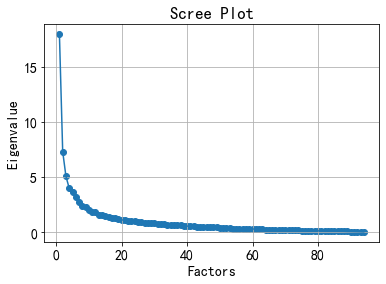

In [643]:

# fa = FactorAnalyzer(5,rotation=None,method='principal')
fa = FactorAnalyzer(4,rotation='promax',method='minres')
# （1）rotation:旋转的方式，包括None:不旋转,'varimax':最大方差法,'promax'：最优斜交旋转；
# （3）method:因子分析的方法，包括'minres':最小残差因子法,'principal':主成分分析法；

fa.fit(tmp2)

ev,v = fa.get_eigenvalues()


# 可视化
# plot横轴是指标个数，纵轴是ev值
# scatter横轴是指标个数，纵轴是ev值

plt.scatter(range(1,tmp2.shape[1]+1),ev)
plt.plot(range(1,tmp2.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

array([-0.47519742, -0.28573198,  0.02169116, -0.02108064])

In [644]:
fa.loadings_

array([[-4.75197420e-01, -2.85731976e-01,  2.16911581e-02,
        -2.10806404e-02],
       [ 1.55132327e-03,  4.63487902e-01,  1.79015161e-01,
        -1.94899228e-01],
       [ 1.50309197e-01, -2.32458799e-01,  2.32743044e-01,
         8.57797117e-01],
       [ 8.28248233e-02,  8.41046581e-01,  9.75772378e-02,
        -9.09610299e-02],
       [ 9.40503649e-02,  3.73000332e-01,  6.06872263e-02,
         2.85531206e-01],
       [ 1.95326159e-01, -2.74650570e-01,  2.30623292e-01,
         8.15792981e-01],
       [ 2.68150186e-01,  4.32748197e-01,  1.53507531e-01,
         2.27799023e-01],
       [ 1.51293141e-01,  5.96577736e-01,  8.91423178e-02,
        -1.56109371e-01],
       [ 8.16442849e-01, -1.82141530e-01,  3.35590600e-02,
         4.94870547e-03],
       [ 8.01751204e-01, -2.89650530e-01, -8.51895159e-02,
         1.99807634e-02],
       [-5.35323942e-02, -2.30435192e-02, -1.08606272e-02,
         2.82642401e-01],
       [ 3.61106741e-01,  8.59259979e-02,  2.24437650e-01,
      

Text(138.65625, 0.5, 'Sepal Width')

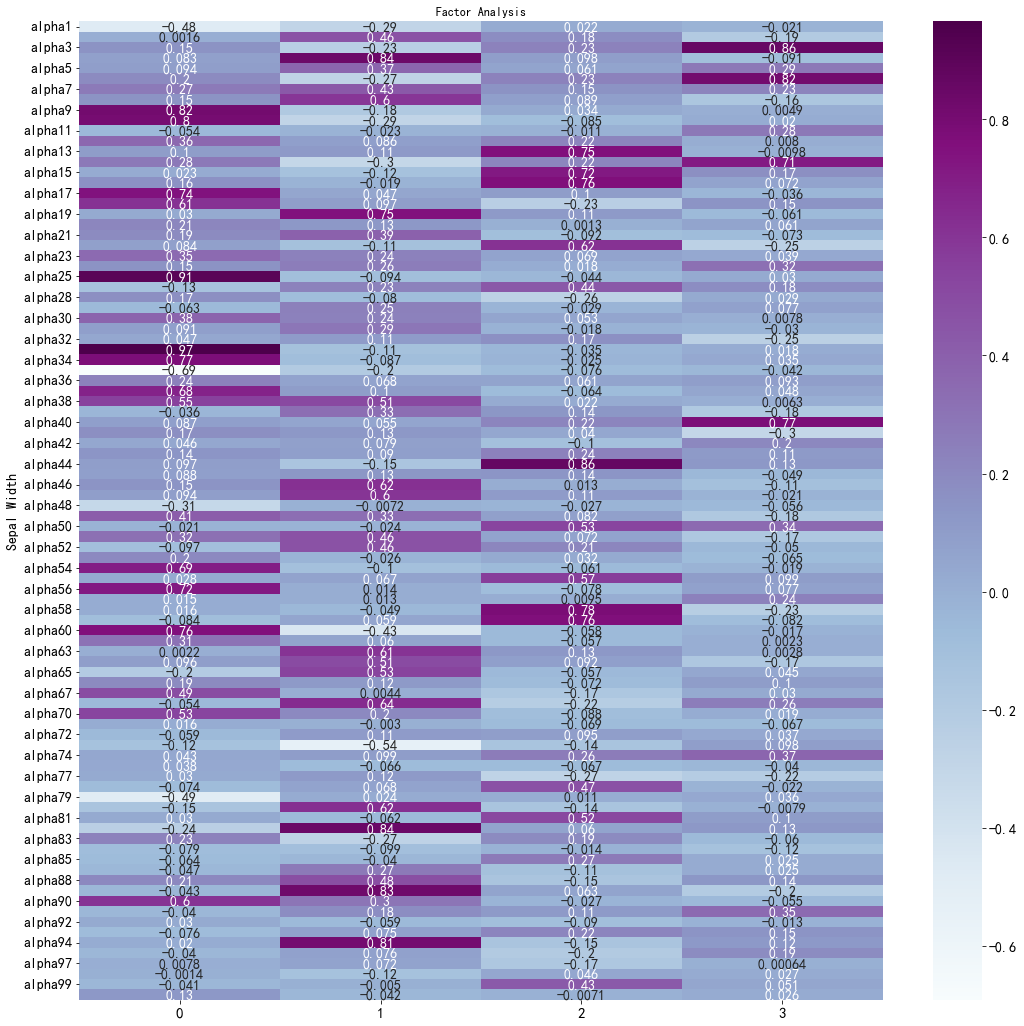

In [645]:
df_cm = pd.DataFrame(fa.loadings_, index=tmp2.columns)  

fig,ax = plt.subplots(figsize=(18,18))
sns.heatmap(df_cm,annot=True,cmap='BuPu',ax=ax)
# 设置y轴字体的大小
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("Sepal Width")

In [646]:
df_cm.apply(lambda x:x.argmax(),axis=1).reset_index().groupby(0).apply(lambda x:print(x['index'].to_list()))

['alpha9', 'alpha10', 'alpha12', 'alpha17', 'alpha18', 'alpha20', 'alpha23', 'alpha25', 'alpha28', 'alpha30', 'alpha33', 'alpha34', 'alpha36', 'alpha37', 'alpha38', 'alpha41', 'alpha49', 'alpha53', 'alpha54', 'alpha56', 'alpha60', 'alpha62', 'alpha66', 'alpha67', 'alpha70', 'alpha71', 'alpha76', 'alpha83', 'alpha90', 'alpha92', 'alpha100']
['alpha2', 'alpha4', 'alpha5', 'alpha7', 'alpha8', 'alpha19', 'alpha21', 'alpha29', 'alpha31', 'alpha39', 'alpha46', 'alpha47', 'alpha48', 'alpha51', 'alpha52', 'alpha63', 'alpha64', 'alpha65', 'alpha69', 'alpha72', 'alpha77', 'alpha80', 'alpha82', 'alpha87', 'alpha88', 'alpha89', 'alpha94', 'alpha97']
['alpha1', 'alpha13', 'alpha15', 'alpha16', 'alpha22', 'alpha26', 'alpha32', 'alpha43', 'alpha44', 'alpha45', 'alpha50', 'alpha55', 'alpha58', 'alpha59', 'alpha78', 'alpha81', 'alpha84', 'alpha85', 'alpha93', 'alpha98', 'alpha99']
['alpha3', 'alpha6', 'alpha11', 'alpha14', 'alpha24', 'alpha35', 'alpha40', 'alpha42', 'alpha57', 'alpha73', 'alpha74', 'al

""


In [671]:
fa.loadings_.argmax(axis=1)


array([0, 2, 0, 3, 2, 0, 0, 1, 1, 3, 1, 3, 2, 0, 3, 1, 1, 0, 0, 0, 3, 0,
       0, 1, 0, 1, 0, 1, 0, 3, 1, 1, 3, 3, 1, 0, 3, 2, 0], dtype=int64)

In [542]:
df_cm_2020.apply(lambda x:x.corr(df_cm_2019[0]),axis=0)

0    0.888591
1   -0.090964
2   -0.368891
3   -0.120850
dtype: float64

In [543]:
df_cm_2020.apply(lambda x:x.corr(df_cm_2019[1]),axis=0)

0   -0.049429
1    0.750150
2   -0.301702
3   -0.048239
dtype: float64

In [544]:
df_cm_2020.apply(lambda x:x.corr(df_cm_2019[2]),axis=0)

0   -0.404390
1   -0.232140
2    0.837877
3   -0.033680
dtype: float64

In [545]:
df_cm_2020.apply(lambda x:x.corr(df_cm_2019[3]),axis=0)

0   -0.303231
1   -0.058306
2    0.201578
3    0.402088
dtype: float64

In [ ]:
# mod = sm.tsa.DynamicFactor(tmp2, k_factors=2, factor_order=2)
# initial_res = mod.fit(method='powell', disp=True)
# res = mod.fit(initial_res.params, disp=True)

# print(res.summary(separate_params=False))
# np.round((res.params[0:10*k_factors].values).reshape(-1,k_factors),2)
# res.plot_coefficients_of_determination(figsize=(8,8));